# Power of Sine Activation

This notebook is a simple demonstration of the power of the sine activation function in neural networks. We will use a nueral network to learn a function mapping that goes from pixel locations to pixel values. 

In nut shell we wish to map

$$f: \mathbb{R}^2 \rightarrow \mathbb{R}^3$$

$$f(x_1, x_2) = R, G, B$$

$$\text{where } R, G, B \in [0, 1] \text{are the pixel intensities for red, green and blue channels respectively}$$
$$\text{and } x_1, x_2 \in [0, 1] \text{are the pixel locations}$$

We will first use a ReLU activation function and then use a sine activation function to see the difference in the results. This demonstration is a simpler usecase of the paper SIREN: Implicit Neural Representations with Periodic Activation Functions by Vincent Sitzmann, Julien N. P. Martel, Alexander W. Bergman, David B. Lindell, Gordon Wetzstein. Available to read at https://arxiv.org/abs/2006.09661. Here is the blog post by the authors https://vsitzmann.github.io/siren/


NOTE : This notebook does not implement the SIREN architecture. It is a simple demonstration of the power of sine activation function in neural networks.

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch.nn as nn
import torch
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device in use ", device)

Device in use  cuda


## Lets load an Image

Say Hello to my CaT!

(1200, 1600, 3)


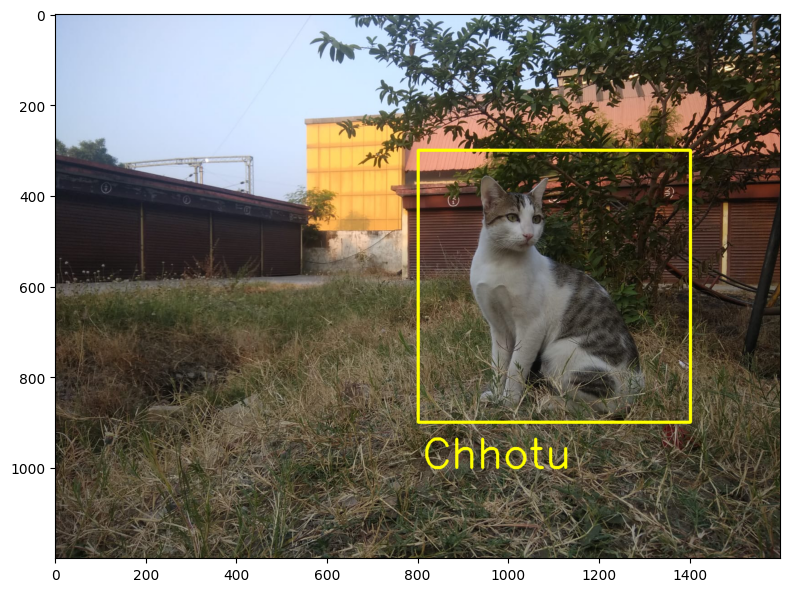

In [35]:
# Read the Image
image = plt.imread('Chhotu.jpeg')

# Create a copy of the image
image_rec = image.copy()

# Draw a rectangle on the image (w1,h1) and (w2,h2)
image_rec = cv.rectangle(image_rec, (800, 300), (1400, 900), (255, 255, 0), 5)
image_rec = cv.putText(image_rec, 'Chhotu', (810, 1000), cv.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 0), 5)

# Display the image
print(image_rec.shape)
plt.figure(figsize=(8, 8))
plt.imshow(image_rec)
plt.tight_layout()
plt.show()

This Image is too big for my GPU to handle. So I will resize it to a smaller size of 300 $\times$ 300 pixels.

(300, 300, 3)


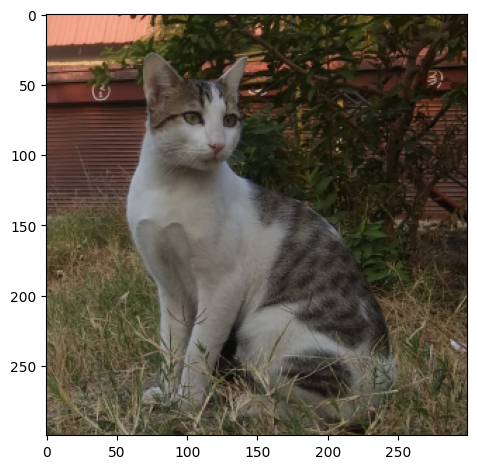

In [37]:
# Crop the image
crop_image = image[300:900, 800:1400]

# Resize the image to make it smaller
crop_image = cv.resize(crop_image, (300, 300))

# Normalize the image to be in the range [0, 1]
crop_image = crop_image/255.0

print(crop_image.shape)
plt.imshow(crop_image)
plt.tight_layout()
plt.show()

## Creating a Coordinate map

We basically wish to create a dataset to train our neural network. The input to the neural network will be the pixel location and the output will be the pixel value. We will create a coordinate map of the image. The coordinate map will have the shape ($Height \times Width$, 2) and Output will have the shape ($Height \times Width$, 3). 

$$\text{Input Coordinate Map to Neural Network} =  \begin{bmatrix} x_1, y_1 \\ x_2, y_2 \\ \vdots \\ x_n, y_n \end{bmatrix} \text{,where } x_i, y_i \text{ are the pixel locations}$$

$$\text{Output Pixel Values} =  \begin{bmatrix} R_1, G_1, B_1 \\ R_2, G_2, B_2 \\ \vdots \\ R_n, G_n, B_n \end{bmatrix} \text{,where } R_i, G_i, B_i \text{ are the pixel intensities}$$


In [38]:
# Create a 2d grid of the image
height, width, channels = crop_image.shape

x_coords = range(height)
y_coords = range(width)

xv, yv = np.meshgrid(y_coords, x_coords)
xv=xv.flatten()
yv=yv.flatten()

X = np.vstack((yv, xv)).T
Y = crop_image.reshape((height*width, 3))

In [39]:
X.shape, Y.shape

((90000, 2), (90000, 3))

Let have a look at what exactly the coordinate map looks like.

In [8]:
X

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [299, 297],
       [299, 298],
       [299, 299]])

## Training a Simple Neural Network with relu activation.

We will train a simple neural network with ReLU activation function to learn the mapping from pixel locations to pixel values. We will use the Adam optimizer and Mean Squared Error loss function. 

$$ Neural Network(x_i, y_i) = \begin{bmatrix} R_i, G_i, B_i \end{bmatrix}$$

All the layers in the neural network will have ReLU activation function except the last layer which will have a linear activation function.

In [42]:
# Create a MLP with 5 hidden layers.
# Input is (x, y) and output is (r, g, b)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = nn.functional.relu(self.fc5(x))
        return self.fc6(x)

### Trainer function and Image plot Function

In [62]:
# Training loop function to train the model
# X: (num_xy, 2) tensor of (x, y) coordinates
# y: (num_xy, 3) tensor of (r, g, b) pixel values
# model: MLP model
# lr: learning rate
# epochs: number of epochs to train for
# bs: batch size
# print_every: print loss every print_every epochs
# Logs losses
# Saves the prediction frmo model every print_every epochs

def train(X, y, model, lr=0.01, epochs=1000, bs=1000, print_every=100):
    """
    Model Trainer : Trains the model

    Parameters:
    X : (num_xy, 2) tensor of (x, y) coordinates
    y : (num_xy, 3) tensor of (r, g, b) pixel values
    model : MLP model 
    lr : learning rate
    epochs : number of epochs to train for
    bs : batch size
    print_every : print loss every print_every epochs

    Returns:
    losses : list of losses
    imgs : list of images predicted by the model every print_every epochs
    """
    losses = []
    imgs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # chosing some random indexes to train the model
        idx = np.random.choice(X.shape[0], bs)
        X_batch = torch.tensor(X[idx], dtype=torch.float32).to(device)
        y_batch = torch.tensor(y[idx], dtype=torch.float32).to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            imgs.append(model(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy())

    return losses, imgs


def plot_image(model, name=None):
    """
    Plot the image predicted by the model
    """
    # Predict the (r, g, b) values
    pred_y = model(torch.tensor(X, dtype=torch.float32).to(device))

    # Reshape the predictions to be (3, height, width)
    pred_y = pred_y.transpose(0, 1).reshape(channels, height, width)

    # plot the image
    plt.imshow(pred_y.permute(1, 2, 0).detach().cpu())
    if name:
        plt.savefig(name)

In [99]:
MLP_model = MLP()
MLP_model.to(device)

relu_losses, relu_imgs = train(X,Y, 
                     MLP_model, lr=0.001, epochs=10000, bs=5000, print_every=1000)


Epoch 0, Loss: 0.6576557755470276
Epoch 1000, Loss: 0.0114674037322402
Epoch 2000, Loss: 0.012357354164123535
Epoch 3000, Loss: 0.008751491084694862
Epoch 4000, Loss: 0.008101350627839565
Epoch 5000, Loss: 0.007827701978385448
Epoch 6000, Loss: 0.010159682482481003
Epoch 7000, Loss: 0.008207915350794792
Epoch 8000, Loss: 0.007177131250500679
Epoch 9000, Loss: 0.006437341216951609


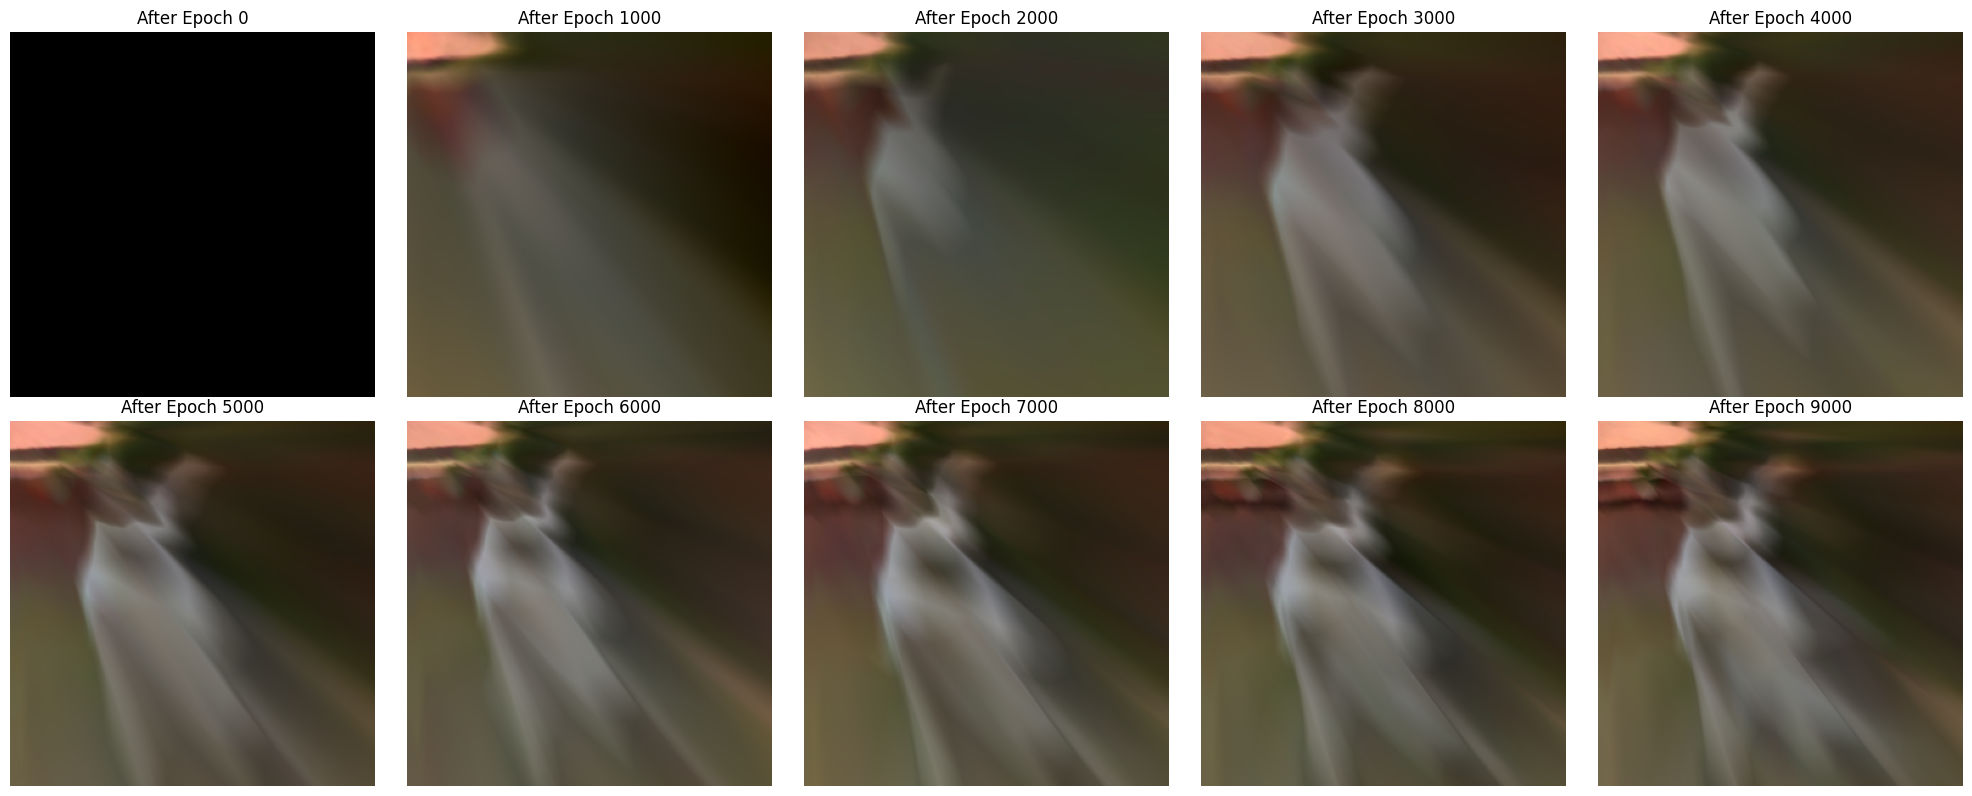

In [100]:
plt.figure(figsize=(20, 8))

for i, img in enumerate(relu_imgs):
    plt.subplot(2, 5, i+1)
    plt.imshow(img.reshape(height, width, 3))
    plt.axis('off')
    plt.title(f'After Epoch {i*1000}')

plt.tight_layout()
plt.show()

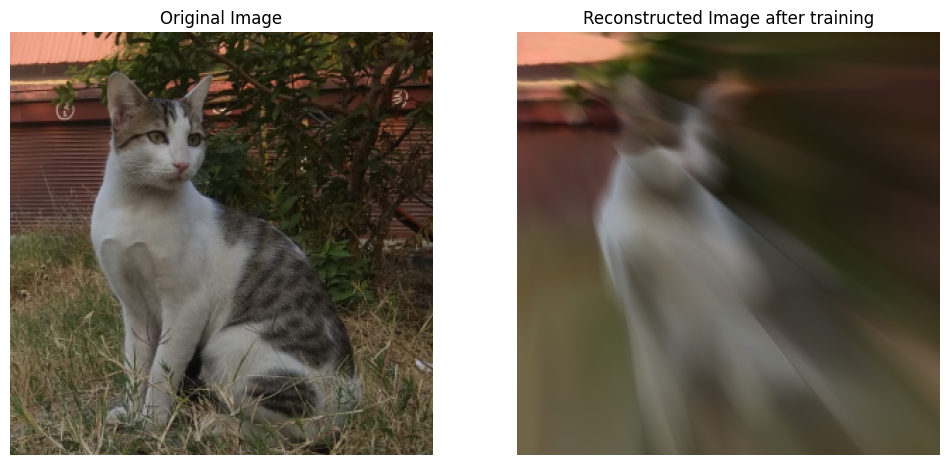

In [122]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(crop_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plot_image(MLP_model)
plt.title('Reconstructed Image after training')
plt.axis('off')
plt.show()

## Training a Simple Neural Network with sine activation.

We will train a simple neural network with ReLU activation function to learn the mapping from pixel locations to pixel values. We will use the Adam optimizer and Mean Squared Error loss function. 

$$ Neural Network(x_i, y_i) = \begin{bmatrix} R_i, G_i, B_i \end{bmatrix}$$

All the layers in the neural network will have Sine activation function except the last layer which will have a linear activation function.

In [102]:
# Create a MLP with 5 hidden layers with 256 neurons each and sine activations.
# Input is (x, y) and output is (r, g, b)

class MLP_sin(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = torch.sin(self.fc3(x))
        x = torch.sin(self.fc4(x))
        x = torch.sin(self.fc5(x))
        return self.fc6(x)

In [103]:
sin_model = MLP_sin()
sin_model.to(device)

sin_losses, sin_imgs = train(X,Y,
                     sin_model, lr=0.001, epochs=10000, bs=5000, print_every=1000)

Epoch 0, Loss: 0.11556914448738098
Epoch 1000, Loss: 0.0018598262686282396
Epoch 2000, Loss: 0.001261448604054749
Epoch 3000, Loss: 0.0007661026320420206
Epoch 4000, Loss: 0.00033592403633520007
Epoch 5000, Loss: 0.00014680986350867897
Epoch 6000, Loss: 9.029130887938663e-05
Epoch 7000, Loss: 8.067893941188231e-05
Epoch 8000, Loss: 8.20108616608195e-05
Epoch 9000, Loss: 7.174971688073128e-05


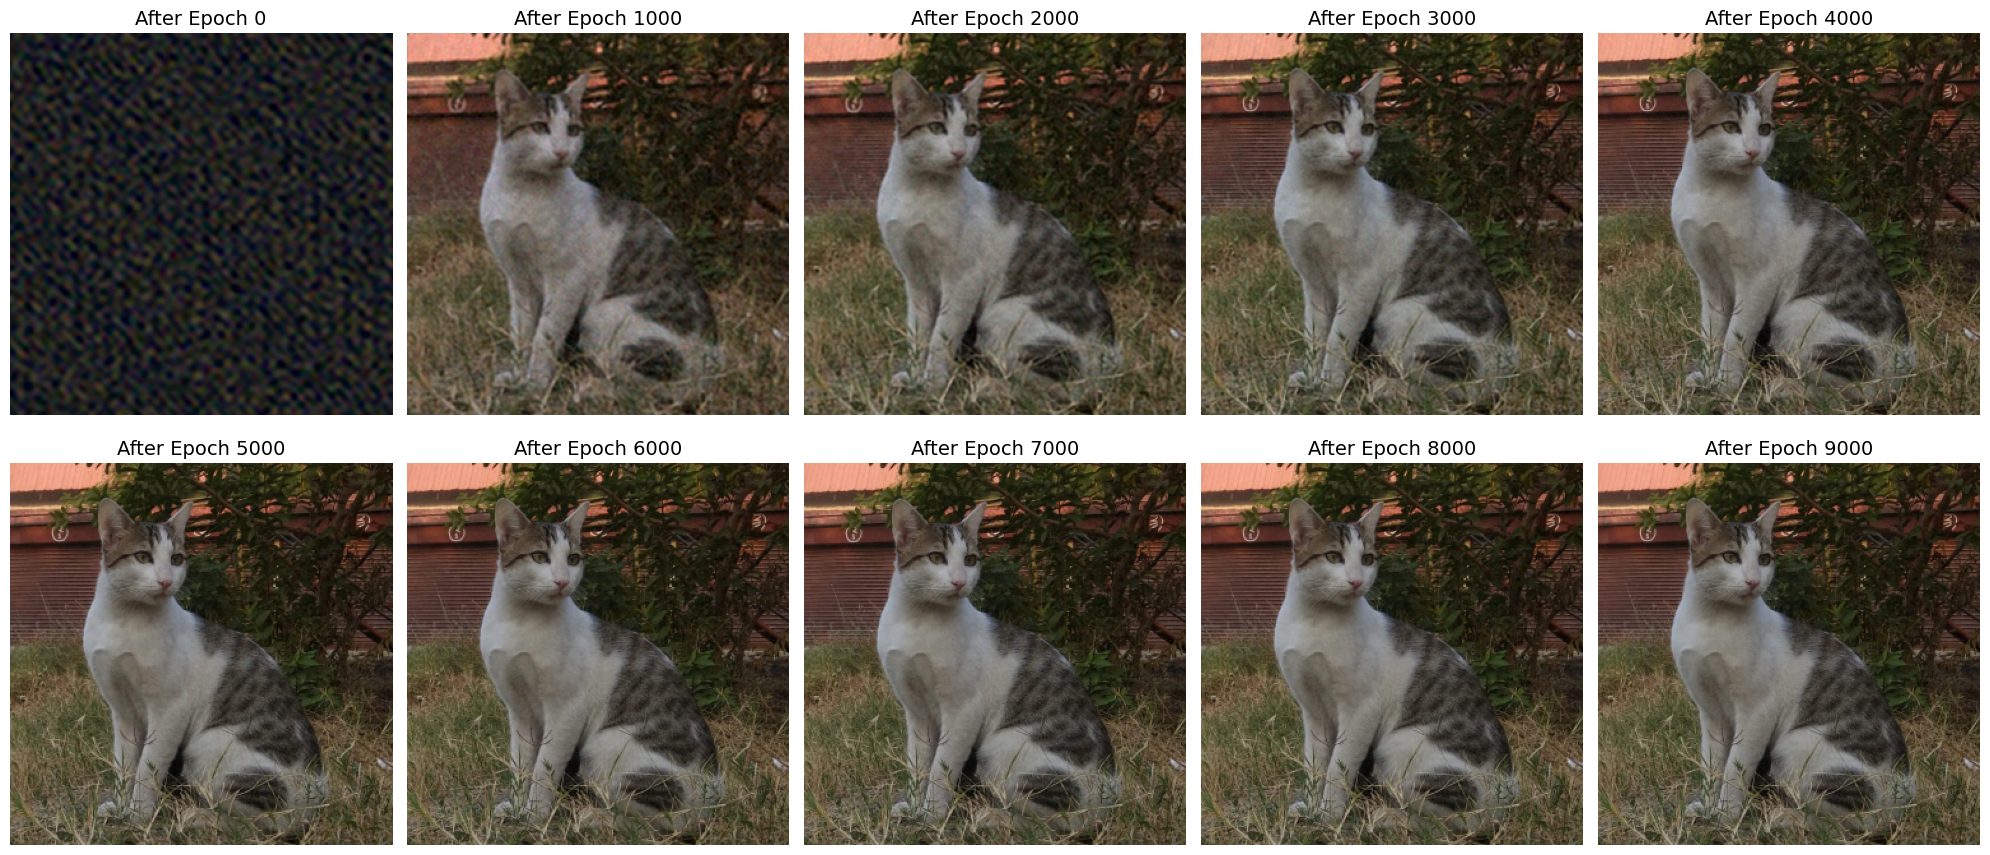

In [118]:
plt.figure(figsize=(20, 9))

for i, img in enumerate(sin_imgs):
    plt.subplot(2, 5, i+1)
    plt.imshow(img.reshape(height, width, 3))
    plt.axis('off')
    plt.title(f'After Epoch {i*1000}', fontsize=14  )

plt.tight_layout()
plt.show()

## Side by Side Comparison of ReLU and Sine Activation

### Image Reconstruction comparison with ReLU and Sine Activation

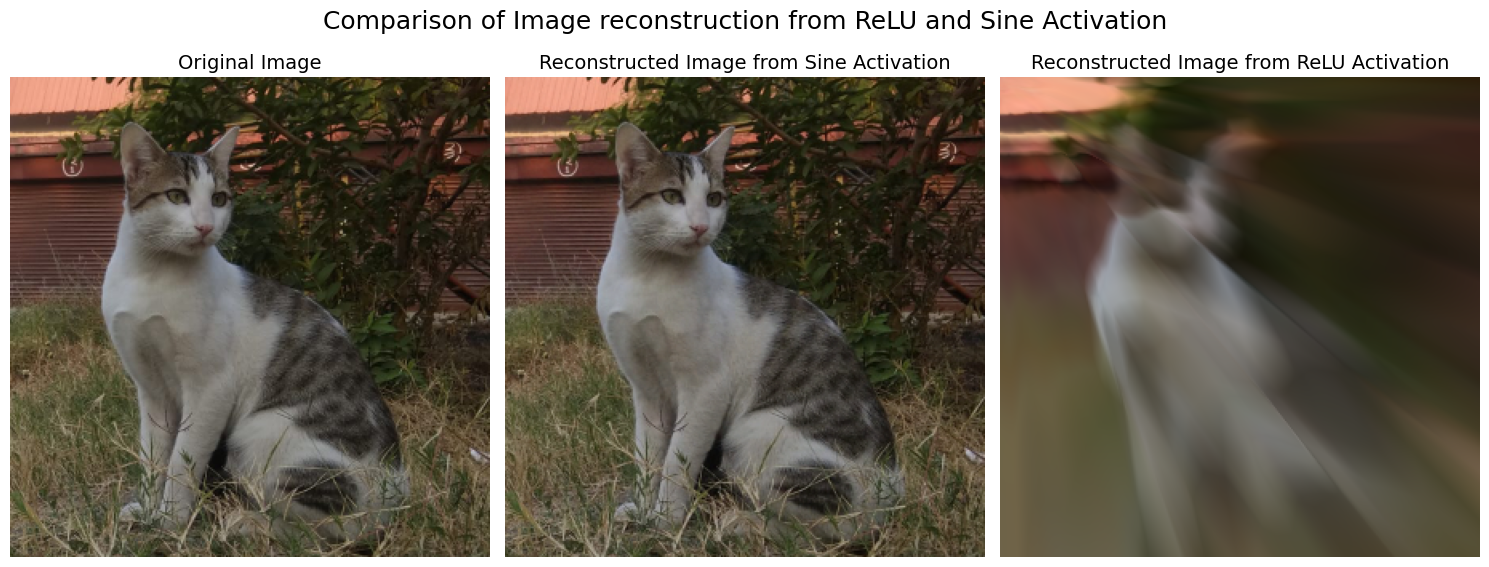

In [123]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(crop_image)
plt.title('Original Image', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 2)
plot_image(sin_model)
plt.title('Reconstructed Image from Sine Activation', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 3)
plot_image(MLP_model)
plt.title('Reconstructed Image from ReLU Activation', fontsize=14)
plt.axis('off')

plt.suptitle('Comparison of Image reconstruction from ReLU and Sine Activation', fontsize=18)
plt.tight_layout()

plt.show()

### Loss Plot Comparison between ReLU and Sine Activation

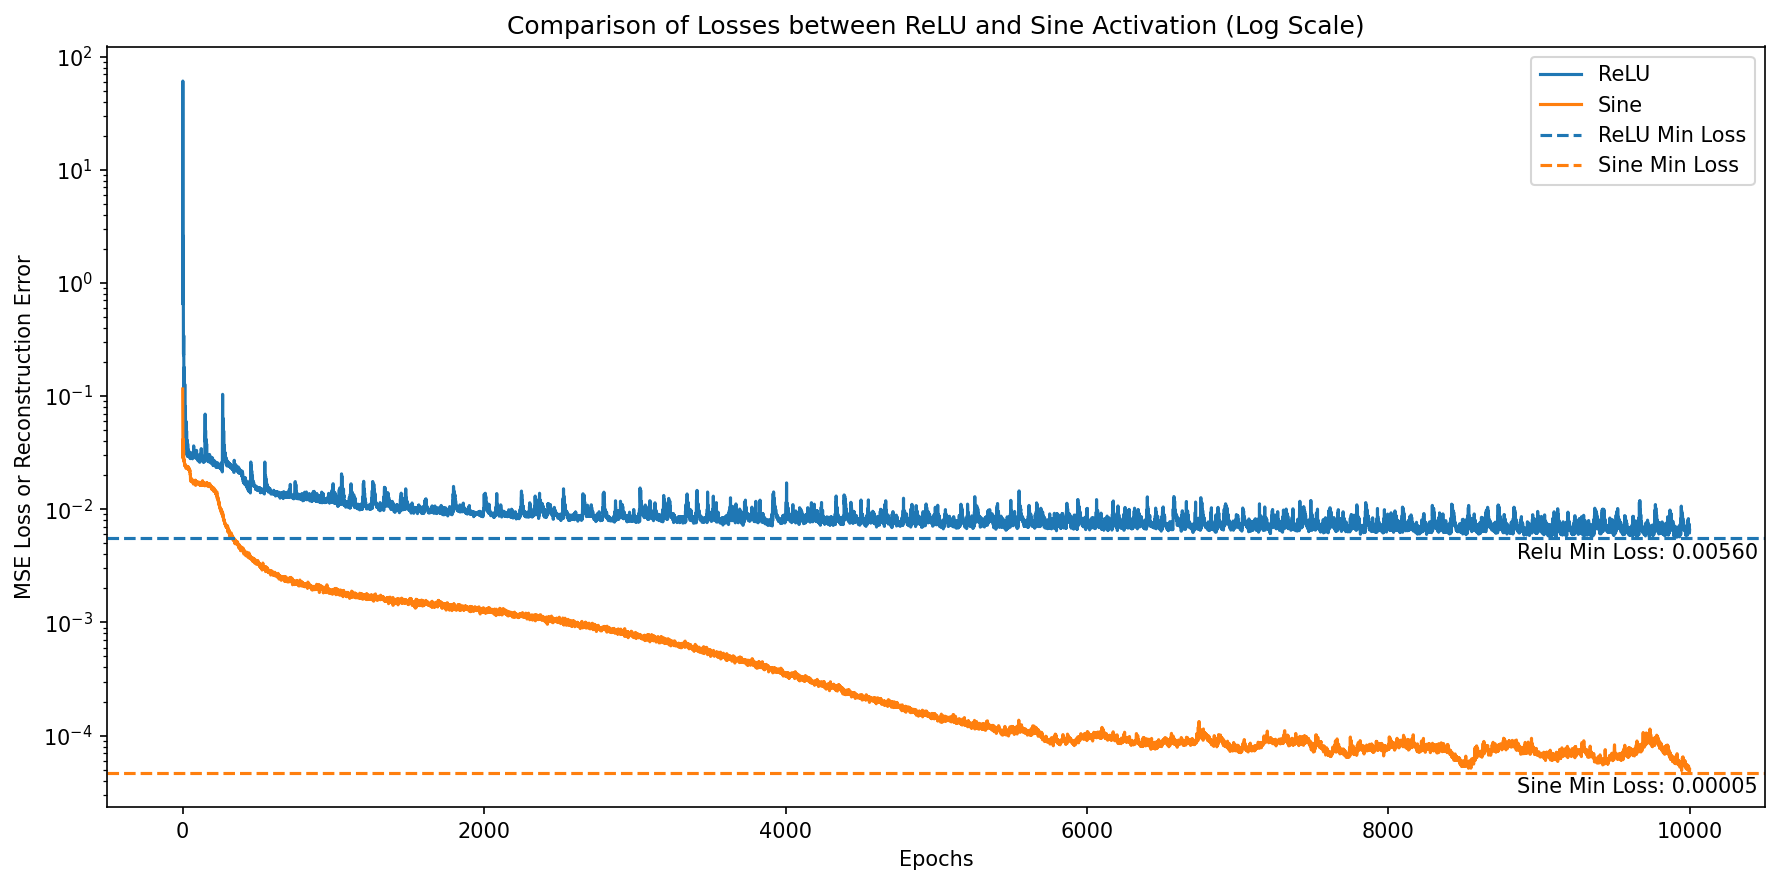

In [142]:
plt.figure(figsize=(12, 6),dpi=150)
plt.plot(relu_losses, label='ReLU')
plt.plot(sin_losses, label='Sine')
plt.axhline(np.min(relu_losses), color='C0', linestyle='--', label='ReLU Min Loss')
plt.axhline(np.min(sin_losses), color='C1', linestyle='--', label='Sine Min Loss')
plt.annotate(f'Relu Min Loss: {np.min(relu_losses):.5f}', (len(relu_losses)-1, np.min(relu_losses)), textcoords="offset points", xytext=(-25,-10), ha='center')
plt.annotate(f'Sine Min Loss: {np.min(sin_losses):.5f}', (len(sin_losses)-1, np.min(sin_losses)), textcoords="offset points", xytext=(-25,-10), ha='center')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss or Reconstruction Error')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.title('Comparison of Losses between ReLU and Sine Activation (Log Scale)')
plt.tight_layout()
plt.show()



# Conclusion

The sine activation function is a powerful activation function that can be used in neural networks to learn complex mappings. Sine converges faster than ReLU activation function and demonstrates better results in image reconstruction tasks.